In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# word by freq 
# wordcloud


In [2]:
import pandas as pd
import numpy as np 
import re

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [89]:
df = pd.read_csv('beforecovid.csv')
df.head() #Filter by dates and then keep text?

df = df[["Date","text"]]

df["Year"] = df["Date"].str.split("-").str[2]



# drop 
# groupby year 
# LDA 
# bert 

In [90]:
df["Year"].value_counts()

19    4842
17    3447
18    3369
20    1804
Name: Year, dtype: int64

In [91]:
df_assigned = df

In [92]:
df_assigned = df_assigned.reset_index(drop=True)

# Data cleaning

In [93]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use']
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))


In [94]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: lemmatization(x))


In [95]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '

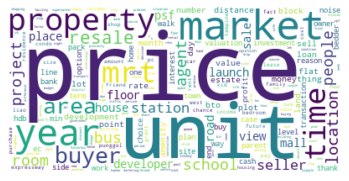

In [96]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_before_covid.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modeling for Text


## Create Corpus 

In [97]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[:3])

[['mine', 'year', 'resale', 'bomb', 'shelter', 'ledge', 'noise', 'traffic', 'supermarket', 'loading', 'bay', 'crazyclubx', 'time', 'house', 'end', 'peace', 'change', 'year', 'move', 'door', 'noise', 'door', 'neighbour', 'r', 'pain'], ['kimurayuki', 'mine', 'year', 'resale', 'bomb', 'shelter', 'ledge', 'noise', 'traffic', 'supermarket', 'loading', 'bay', 'mine', 'year', 'resale', 'home', 'traffic', 'road', 'traffic', 'noise', 'aircon', 'noise', 'neighbour', 'door', '2am', 'thing', '3am', 'timing', 'time', 'ppl', 'sleep', 'shld', 'inconsiderate', 'neighbour'], ['punggolbto', 'model', 'floor', 'plan', 'building', 'bto', 'view', 'unit', 'area', 'site', 'word', 'price', 'proximity', 'station', 'monkey', 'island', 'venture', 'food']]


In [98]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [99]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'bay'), (1, 'bomb'), (2, 'change'), (3, 'crazyclubx'), (4, 'door'), (5, 'end'), (6, 'house'), (7, 'ledge'), (8, 'loading'), (9, 'mine'), (10, 'move'), (11, 'neighbour'), (12, 'noise'), (13, 'pain'), (14, 'peace'), (15, 'r'), (16, 'resale'), (17, 'shelter'), (18, 'supermarket'), (19, 'time'), (20, 'traffic'), (21, 'year'), (22, '2am'), (23, '3am'), (24, 'aircon'), (25, 'home'), (26, 'inconsiderate'), (27, 'kimurayuki'), (28, 'ppl'), (29, 'road'), (30, 'shld'), (31, 'sleep'), (32, 'thing'), (33, 'timing'), (34, 'area'), (35, 'bto'), (36, 'building'), (37, 'floor'), (38, 'food'), (39, 'island'), (40, 'model'), (41, 'monkey'), (42, 'plan'), (43, 'price'), (44, 'proximity'), (45, 'punggolbto'), (46, 'site'), (47, 'station'), (48, 'unit'), (49, 'venture')]

Total Vocabulary Size: 7811


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [100]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [101]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5891523916171928
Perplexity Score:  -6.833870699173343

topic number:  3
Coherence Score:  0.6019036806339606
Perplexity Score:  -6.8099510274997215

topic number:  4
Coherence Score:  0.621849454058202
Perplexity Score:  -6.790915144994491

topic number:  5
Coherence Score:  0.6109825201327824
Perplexity Score:  -6.831704510564231

topic number:  6
Coherence Score:  0.6045085924813146
Perplexity Score:  -6.843048611553435

topic number:  7
Coherence Score:  0.6260030484666511
Perplexity Score:  -6.848206612453228

topic number:  8
Coherence Score:  0.5969949935854617
Perplexity Score:  -6.861839652778757

topic number:  9
Coherence Score:  0.59977881256433
Perplexity Score:  -6.894367849319419

topic number:  10
Coherence Score:  0.56649691313717
Perplexity Score:  -6.9570253724735185

topic number:  11
Coherence Score:  0.5809216627957575
Perplexity Score:  -7.144970163450138

topic number:  12
Coherence Score:  0.5619798179575514
Perplexity Score

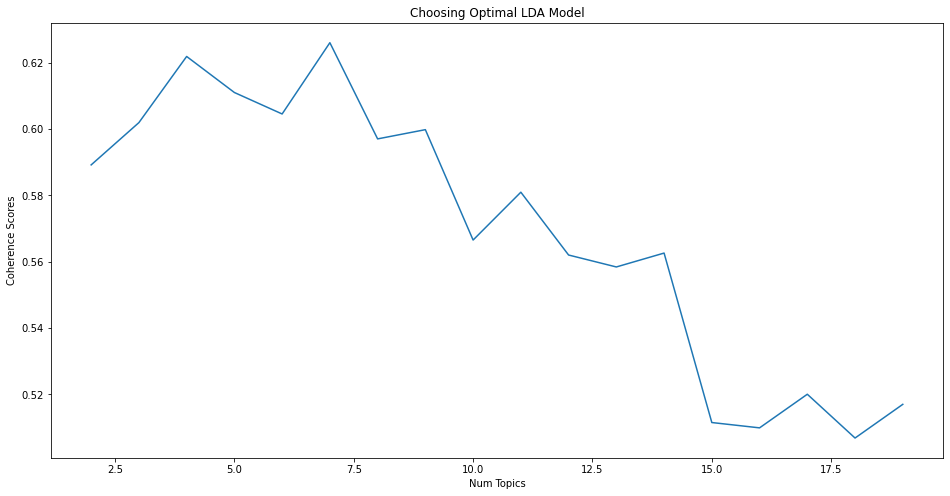

In [102]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [112]:
ntopics_des_name = 7

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [113]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.060*"year" + 0.037*"resale" + 0.021*"loan" + 0.018*"market" + '
  '0.018*"house" + 0.017*"cash" + 0.017*"grant" + 0.017*"room" + 0.016*"rent" '
  '+ 0.016*"income"'),
 (1,
  '0.057*"unit" + 0.027*"floor" + 0.021*"room" + 0.020*"noise" + 0.017*"view" '
  '+ 0.015*"number" + 0.014*"expressway" + 0.012*"level" + 0.012*"road" + '
  '0.012*"sun"'),
 (2,
  '0.046*"school" + 0.026*"time" + 0.016*"people" + 0.013*"kid" + 0.012*"work" '
  '+ 0.009*"hospital" + 0.009*"job" + 0.008*"housing" + 0.008*"land" + '
  '0.008*"home"'),
 (3,
  '0.044*"price" + 0.035*"project" + 0.028*"launch" + 0.027*"psf" + '
  '0.026*"unit" + 0.021*"location" + 0.019*"development" + 0.015*"mrt" + '
  '0.015*"developer" + 0.014*"bedder"'),
 (4,
  '0.063*"market" + 0.062*"property" + 0.048*"%" + 0.043*"price" + '
  '0.030*"year" + 0.024*"rate" + 0.019*"time" + 0.016*"developer" + '
  '0.011*"people" + 0.011*"bank"'),
 (5,
  '0.050*"mrt" + 0.041*"bus" + 0.030*"area" + 0.027*"station" + 0.019*"block" '
  '+ 0.018

In [114]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [115]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [116]:
df_assigned['Topic'] = topic_num

In [117]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

,Date,text,clean_text,Topic
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...","[mine, year, resale, bomb, shelter, ledge, noi...","[1, 0]"
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,"[kimurayuki, mine, year, resale, bomb, shelter...","[1, 0]"
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,"[punggolbto, model, floor, plan, building, bto...","[1, 5, 3]"
3,19-Oct-18,I have just purchased a resale flat recently w...,"[resale, agent, unit, renovation, source, info...","[6, 1]"
4,20-Oct-18,"Just to add, go to hdb website and check recen...","[hdb, website, resale, transaction, market, pr...","[6, 4]"


In [38]:
# des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [118]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.84448920902774
Coherence Score:  0.5938804956556901


## Visualisation

In [119]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [120]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.198404 -0.103026       1        1  18.656130
5      0.347065 -0.062117       2        1  16.797708
1      0.082042  0.112856       3        1  16.106500
6     -0.145273 -0.039059       4        1  15.556680
3      0.023186 -0.238561       5        1  15.167197
0     -0.100506  0.060697       6        1  10.905927
2     -0.008111  0.269211       7        1   6.809858, topic_info=         Term         Freq        Total Category  logprob  loglift
197  property  3787.000000  3787.000000  Default  30.0000  30.0000
43      price  7819.000000  7819.000000  Default  29.0000  29.0000
48       unit  7342.000000  7342.000000  Default  28.0000  28.0000
55      agent  2537.000000  2537.000000  Default  27.0000  27.0000
390       mrt  3503.000000  3503.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
201       way   128.928160   895.500794   Topic7  -5.1463   0.7487
57       bank   112.740561   834.211823   Topic7  -5.2805   0.6854
356    estate   112.697757   975.658635   Topic7  -5.2809   0.5284
194     money   105.776008  1032.896240   Topic7  -5.3443   0.4080
42       plan   102.046581   630.748174   Topic7  -5.3802   0.8653

[460 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
149       1  0.879166           %
149       4  0.062218           %
149       6  0.058310           %
2029      4  0.984746         10k
304       1  0.991569     1200psf
...     ...       ...         ...
21        6  0.386420        year
21        7  0.017490        year
616       1  0.866177       yield
616       5  0.127647       yield
3649      7  0.987723  zetrio2006

[757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 7, 4, 1, 3])

## Word Count of Topic Keywords

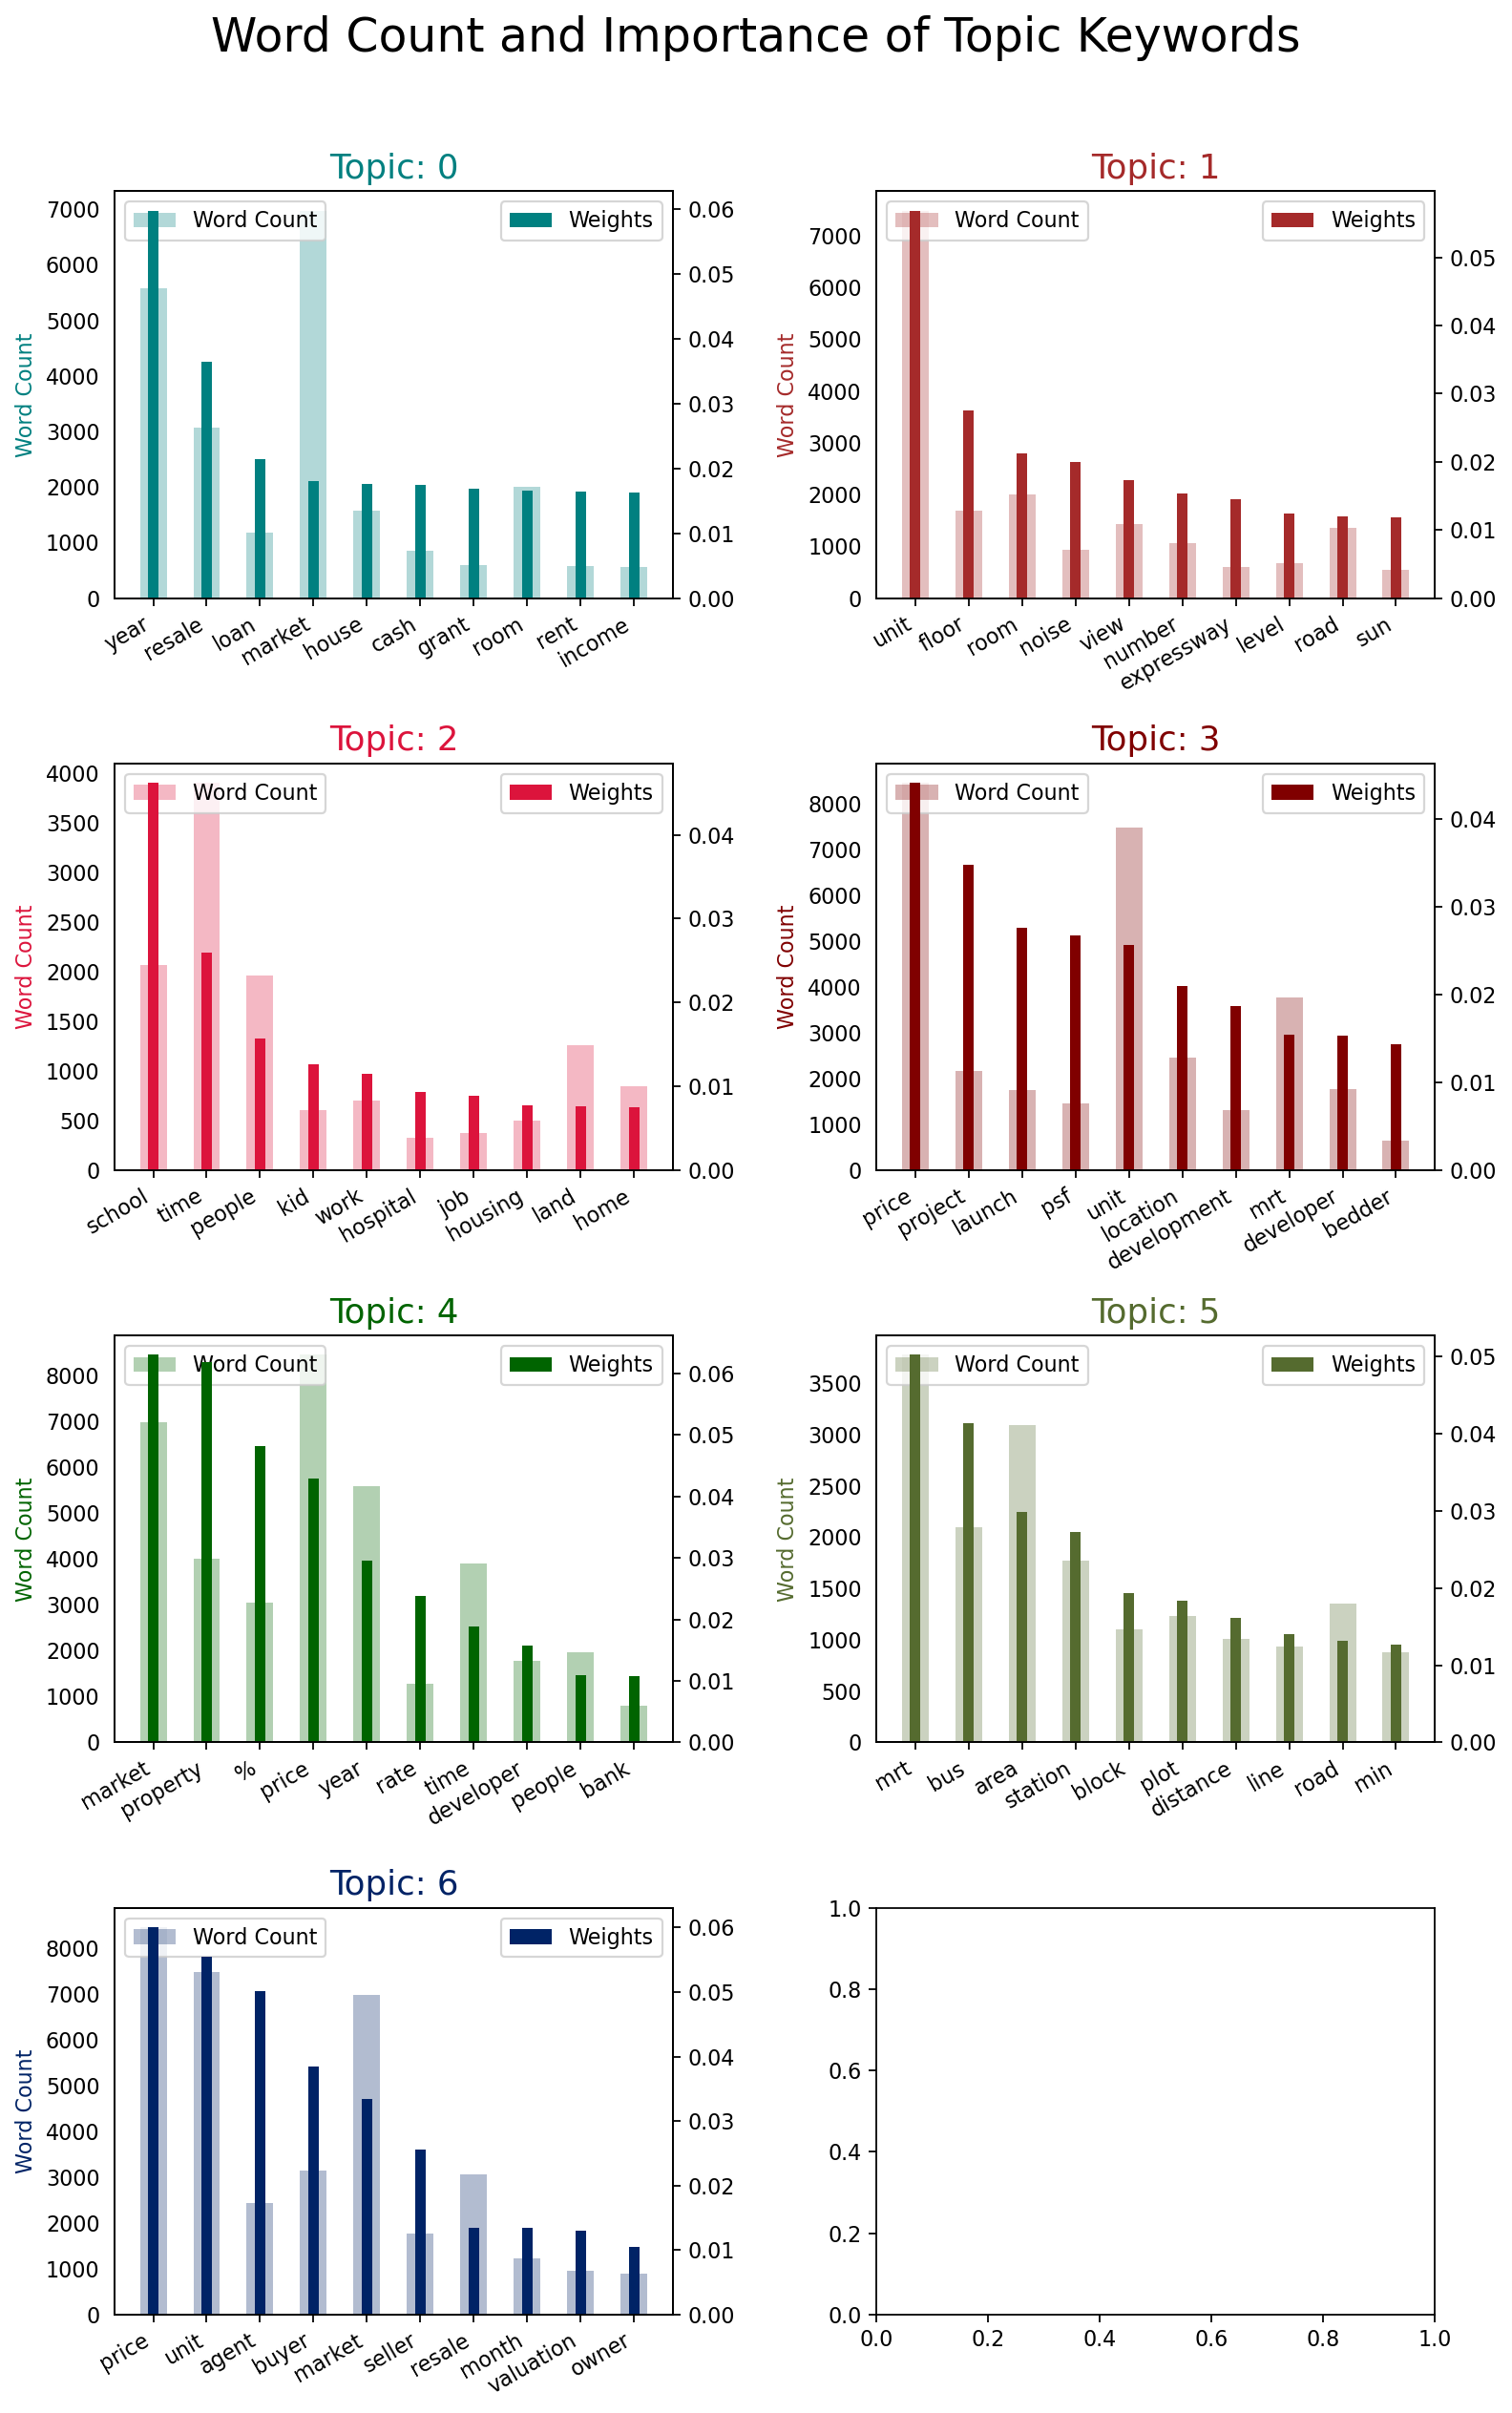

In [121]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('lda_topics_before_unigram.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()


In [ ]:
# jonathan, [24/10/2022 3:27 PM]
# cv1 = CountVectorizer(min_df=3, stop_words='english', ngram_range= (1,2))
# cv1_vect = cv1.fit_transform(tweet_corpus)
# print(cv1.get_feature_names())

# jonathan, [24/10/2022 3:27 PM]
# def process_text(documents):
#     processed_tokens = []
#     doc_tokens = []
#     for doc in documents:
#         doc = doc.lower()  # change all characters to lower case
#         doc = remove_urls(doc) # remove URLs
#         doc_tokens = retokenizer.tokenize(doc) # remove punctuations and tokenize the documents
#         doc_tokens = [token for token in doc_tokens if token not in stop_words] # remove stop words
#         doc_tokens = [wnl.lemmatize(token) for token in doc_tokens] # lemmatize the words
#         processed_tokens.append(doc_tokens) # save the pre-processed tokens to a variable called processed_tokens
#     return processed_tokens